In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim
from adjustText import adjust_text
import multiprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [8]:
cores = multiprocessing.cpu_count()

In [10]:
df_data = pd.read_csv('../Data/data_2/clean_review_160k.csv')

In [11]:
encoding_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}

In [12]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

,text,rating,label
0,near airport good shuttle service stay night w...,2.0,2
1,get low rank reason positive thing say hotel s...,1.0,2
2,budget hotel pretend resort ORG ORG really mot...,2.0,2
3,dish extra buck stay elsewhere place look acce...,1.0,2
4,l budget good low cost brand hotel near downto...,2.0,2
...,...,...,...
141740,fantastic mid range hotel u find well GPE stay...,5.0,0
141741,fantastic service staff encounter property mak...,4.0,0
141742,great find stay DATE previously stay theatre d...,4.0,0
141743,convenient location airport stay start road tr...,4.0,0


In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((113396,), (14174,), (113396,), (14174,), (14175,), (14175,))

In [14]:
sentences = df_data['text'].str.split().tolist()

model_wv = gensim.models.Word2Vec(sentences, vector_size=200, window=9, min_count=1, workers=cores-1)

In [15]:
words = list(model_wv.wv.key_to_index)[:200]
embeddings = model_wv.wv[words]

pca = PCA(n_components=10, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(pca)

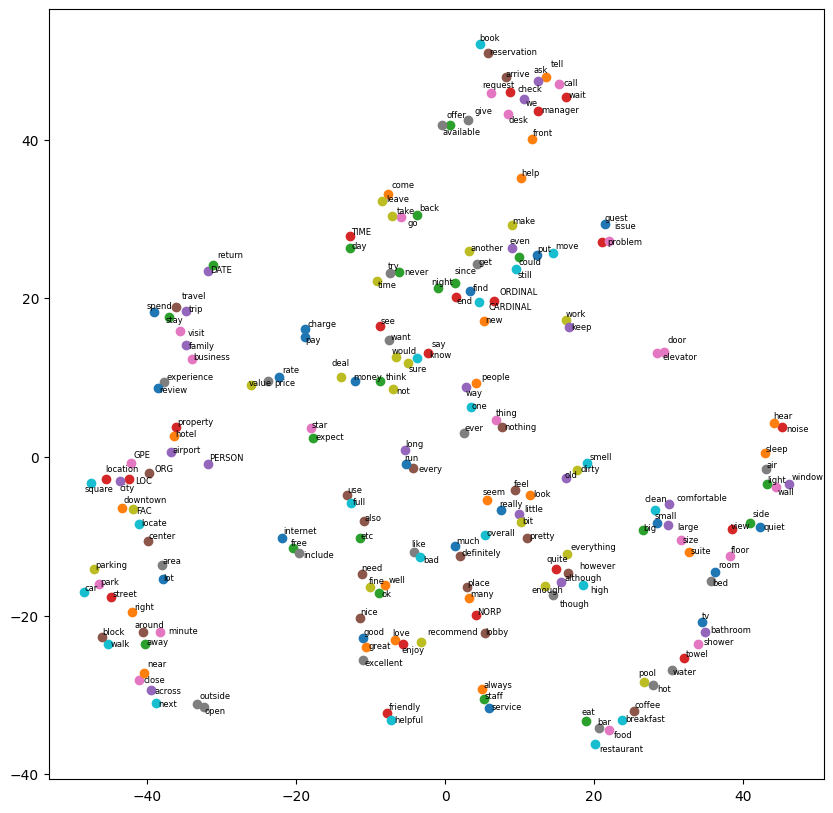

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, word in enumerate(words):
    x, y = embeddings_2d[i]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=6)

adjust_text(ax.texts)
plt.show()

In [17]:
MAXLEN = 32
MAX_EXAMPLES = len(model_wv.wv.key_to_index)
EMBEDDING_DIM = model_wv.wv.vector_size
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = '<OOV>'
NUM_LABELS = 5

embedding_matrix = np.zeros((MAX_EXAMPLES, EMBEDDING_DIM))
for word, i in model_wv.wv.key_to_index.items():
    embedding_matrix[i] = model_wv.wv[word]

In [18]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_val_pad = pad_sequences(x_val_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN,weights=[embedding_matrix], trainable=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           13130400  
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense (Dense)               (None, 64)                409664    
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,540,389
Trainable params: 13,540,389
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test))

Epoch 1/10
3544/3544 [==============================] - 517s 146ms/step - loss: 0.7405 - accuracy: 0.6621 - val_loss: 0.6455 - val_accuracy: 0.7155
Epoch 2/10
3544/3544 [==============================] - 508s 143ms/step - loss: 0.5672 - accuracy: 0.7558 - val_loss: 0.6451 - val_accuracy: 0.7162
Epoch 3/10
3544/3544 [==============================] - 465s 131ms/step - loss: 0.4778 - accuracy: 0.7978 - val_loss: 0.6733 - val_accuracy: 0.7172
Epoch 4/10
3544/3544 [==============================] - 474s 134ms/step - loss: 0.3815 - accuracy: 0.8440 - val_loss: 0.7756 - val_accuracy: 0.7024
Epoch 5/10
3544/3544 [==============================] - 458s 129ms/step - loss: 0.2945 - accuracy: 0.8809 - val_loss: 0.9591 - val_accuracy: 0.6980
Epoch 6/10
3544/3544 [==============================] - 476s 134ms/step - loss: 0.2222 - accuracy: 0.9122 - val_loss: 1.1943 - val_accuracy: 0.6889
Epoch 7/10
3544/3544 [==============================] - 498s 141ms/step - loss: 0.1667 - accuracy: 0.9346 - val_

In [21]:
val_accuracy, val_loss = model.evaluate(x_val_pad, y_val)

443/443 [==============================] - 1s 1ms/step - loss: 2.1004 - accuracy: 0.6851


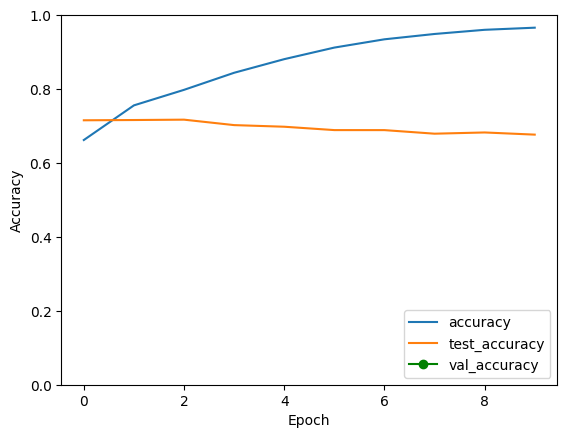

In [22]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.plot(val_accuracy, label='val_accuracy',marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [23]:
predictions = model.predict(x_val_pad)
predictions = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_val, predictions)

443/443 [==============================] - 1s 1ms/step


NameError: name 'sns' is not defined

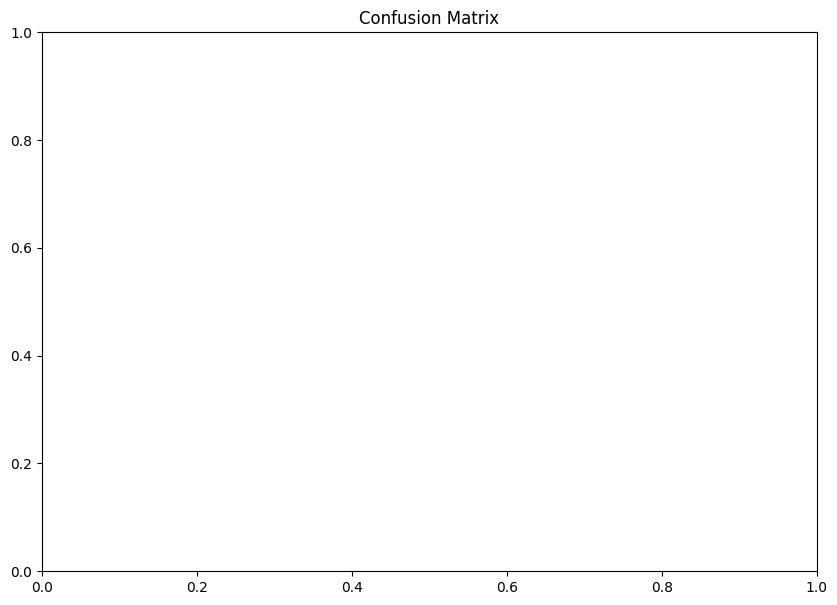

In [24]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()